## **HITL: Human In The Loop**
- `Topic >---> LinkedIn Post >---> HITL >---> Post on LinkedIn(API)`
- `Topic >---> LinkedIn Post >---> HITL(Interupt, Resume) >---> Post on LinkedIn(API)`

In [1]:
import sqlite3
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt
from langchain_ollama import ChatOllama
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.checkpoint.sqlite import SqliteSaver


In [2]:
# ===================== MODEL =====================
model = ChatOllama(
    model="qwen2.5:0.5b",
    temperature=0.3
)


In [3]:
# ===================== STATE =====================
class PostState(TypedDict):
    topic: str
    search: str
    post: str
    approved: bool
    iteration: int
    max_iteration: int


In [4]:
# ===================== TOOLS =====================
search_tool = DuckDuckGoSearchRun(name="Search")


In [5]:
# ===================== NODES =====================
def search_topic(state: PostState):
    query = f"Latest updates, statistics, reforms, and developments about {state['topic']}"
    results = search_tool.run(query)
    return {"search": results}


def generate_post(state: PostState):
    prompt = [
        SystemMessage(
            content="""
                You are a professional AI/ML & GenAI Engineer with strong technical and communication skills.
                You write high-quality, original LinkedIn posts for a professional audience including
                software engineers, AI practitioners, and tech leaders.
                
                Your writing style is:
                - Clear, concise, and professional
                - Informative but not academic
                - Confident but not promotional
                - Easy to skim (short paragraphs, logical flow)
                """
            ),
        HumanMessage(
            content=f"""
                TASK:
                Write a professional LinkedIn post on the topic below.
                
                TOPIC:
                {state['topic']}
                
                REFERENCE INFORMATION:
                Use the following research material strictly as context and factual grounding.
                Do NOT copy text verbatim.
                Summarize, synthesize, and rephrase in your own words.
                
                {state['search']}
                
                WRITING GUIDELINES:
                - Start with a strong opening hook (1–2 lines)
                - Clearly explain why the topic matters today
                - Highlight 2–3 key insights or developments
                - Keep the tone professional and practical
                - Avoid emojis, hashtags, or excessive formatting
                - Length: 120–180 words
                - Do NOT mention being an AI or language model
                
                OUTPUT:
                Return only the final LinkedIn post content.
                """
            )
        ]

    post = model.invoke(prompt).content

    return {
        "post": post,
        "approved": False,
        "iteration": state["iteration"] + 1
    }


def human_review(state: PostState):
    print("\n" + "="*70)
    print(f"👤 HUMAN REVIEW REQUIRED - Iteration: {state['iteration']}/{state['max_iteration']}")
    print("Topic:", state["topic"])
    print("\nPROPOSED POST:\n")
    print(state["post"])
    print("\n" + "="*70)
    print("\n"*3)
    
    while True:
        if state['iteration'] >= state['max_iteration']:
            print("Your approval limit exceeded.")
            break
        
        decision = input("Approve this post? (yes / no): ").strip().lower()
        
        if decision in ["yes", "y"]:
            return {"approved": True}
            
        elif decision in ["no", "n"]:
            return {"approved": False}
    
    return {"approved": True}
    

def check_condition(state: PostState):
    if state["approved"]:
        return "finalize_post"
    if state["iteration"] >= state["max_iteration"]:
        return "finalize_post"
    return "generate_post"


def finalize_post(state: PostState):
    print("\n✅ Finalizing output. Ready for LinkedIn.")
    print("\n" + "="*70)
    print("Topic:", state["topic"])
    print("\nPROPOSED POST:\n")
    print(state["post"])
    print("\n" + "="*70)
    return state


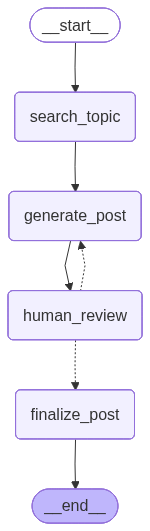

In [6]:
# ===================== GRAPH =====================
graph = StateGraph(PostState)

graph.add_node("search_topic", search_topic)
graph.add_node("generate_post", generate_post)
graph.add_node("human_review", human_review)
graph.add_node("finalize_post", finalize_post)

graph.add_edge(START, "search_topic")
graph.add_edge("search_topic", "generate_post")
graph.add_edge("generate_post", "human_review")

graph.add_conditional_edges(
    "human_review",
    check_condition,
    {
        "generate_post": "generate_post",
        "finalize_post": "finalize_post",
    }
)

graph.add_edge("finalize_post", END)

# ===================== CHECKPOINTER =====================
conn = sqlite3.connect("LinkedIn_Post.db", check_same_thread=False)
checkpointer = SqliteSaver(conn)

workflow = graph.compile(checkpointer=checkpointer)
workflow

In [7]:

# ===================== RUN (JUPYTER) =====================

config = {
    "configurable": {
        "thread_id": "post-1"
    }
}

initial_state = {
    "topic": "Era of Aritificial Intelligence",
    "search": "",
    "post": "",
    "approved": False,
    "iteration": 0,
    "max_iteration": 4,
}

response = workflow.invoke(initial_state, config=config)
# print(response['post'])



👤 HUMAN REVIEW REQUIRED - Iteration: 1/4
Topic: Era of Aritificial Intelligence

PROPOSED POST:

In today's world of artificial intelligence (AI), the future is rapidly evolving. As we look to the mid-2025s, it's clear that the potential for AI to transform industries and drive innovation is immense. From the advancements in machine learning and natural language processing to the development of autonomous vehicles and smart homes, the possibilities are endless.

One key development that has the potential to shape the future of AI is the integration of AI into various sectors. As we move towards a more digital economy, it's clear that AI will play an increasingly important role in shaping our world. By leveraging AI technologies, organizations can improve their efficiency, reduce costs, and gain a competitive edge.

Another area where AI has the potential to make a significant impact is in healthcare. With the increasing availability of genomic data, AI can be used to analyze medical i

Approve this post? (yes / no):  yes



✅ Finalizing output. Ready for LinkedIn.

Topic: Era of Aritificial Intelligence

PROPOSED POST:

In today's world of artificial intelligence (AI), the future is rapidly evolving. As we look to the mid-2025s, it's clear that the potential for AI to transform industries and drive innovation is immense. From the advancements in machine learning and natural language processing to the development of autonomous vehicles and smart homes, the possibilities are endless.

One key development that has the potential to shape the future of AI is the integration of AI into various sectors. As we move towards a more digital economy, it's clear that AI will play an increasingly important role in shaping our world. By leveraging AI technologies, organizations can improve their efficiency, reduce costs, and gain a competitive edge.

Another area where AI has the potential to make a significant impact is in healthcare. With the increasing availability of genomic data, AI can be used to analyze medical 